# load DAS clean data and make movie

To do

- [ ] add wind
- [ ] shallow
- [ ] slope


In [1]:
import os
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import dashydro.hydro as hy

---

## load data

In [2]:
deployment = "2019_summer_toulon"

# load info
dinfo = hy.deployments_info[deployment]
raw_data_dir = dinfo["raw_dir"]
processed_data_dir = dinfo["processed_dir"]

In [3]:
# load das data
zarr = os.path.join(processed_data_dir, "dast_L1A.zarr")
ds = xr.open_zarr(zarr)

In [5]:
# load wind

# define points of interest
if dinfo["site"]=="toulon":
    lonp = [5.904, 5.904]
    latp = [43.045, 42.9]
    labels = ["nearshore", "offshore"]
elif dinfo["site"]=="monaco":
    assert False, "need to define points"

# load arome data
wd = xr.open_dataset(os.path.join(processed_data_dir, "wind_arome.nc"))
# adjust stress such that it's not a cummulled estimate
# see https://donneespubliques.meteofrance.fr/client/document/description_parametres_modeles-arpege-arome-v2_184.pdf
wd["ustress"] = wd["ustress"]/3600
wd["vstress"] = wd["vstress"]/3600
wd["speed10m"] = np.sqrt(wd.u10m**2+wd.v10m**2)
wd["dir10m"] = np.arctan2(wd.v10m, wd.u10m)*180/np.pi
wd["stress"] = np.sqrt(wd.ustress**2+wd.vstress**2)


wdp = xr.Dataset(dict(lon=("point", lonp), lat=("point", latp)))
wdp = wd.interp(longitude=wdp.lon, latitude=wdp.lat).assign_coords(point=("point", labels))

In [6]:
dt = float((ds.time[1]-ds.time[0])/pd.Timedelta("1T"))
print(f"Time sampling : dt = {dt} min")

Time sampling : dt = 2.0 min


---

## overview

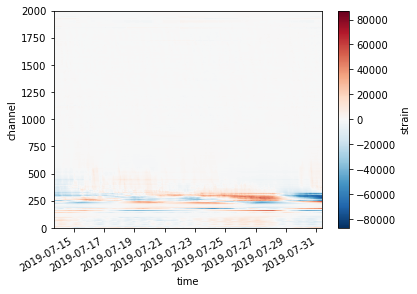

In [7]:
ds.strain.isel(time=slice(0,None,5)).plot(x="time")

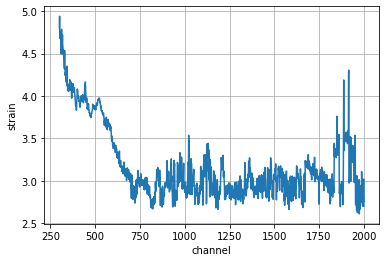

In [46]:
np.log10(np.abs(ds.strain)).max("time").sel(channel=slice(300,2000)).plot()
plt.grid()

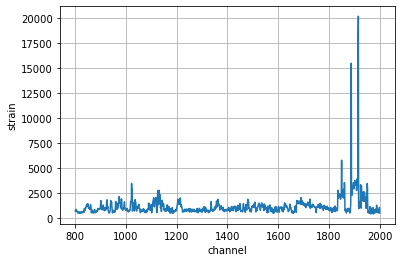

In [62]:
toplt = np.abs(ds.strain)
#toplt = np.log10(toplt)
toplt = toplt.max("time")
toplt.sel(channel=slice(800,2000)).plot()
plt.grid()

---

## make movie

In [59]:
# dast only

def map_dast(ds, ylims=None):

    fig, ax = plt.subplots(1,1,figsize=(15,5))
    ax.plot(ds.channel, ds.strain, color="k", lw=2)
    
    if ylims is not None:
        ax.set_ylim(ylims)
    ax.grid()
    
    return fig

# add bathy

def map_dast_bathy(ds, ylims=None):

    fig = plt.figure(figsize=(15,5), constrained_layout=True)
    axes = fig.subplot_mosaic(
        [["top"],["bottom"]],
        gridspec_kw={"height_ratios": [3, 2,],},
        sharex=True,
    )
    
    ax = axes["top"]
    ax.plot(ds.channel, ds.strain, color="k", lw=2)
    
    if ylims is not None:
        ax.set_ylim(ylims)
    ax.grid()

    
    ax = axes["bottom"]
    ax.plot(ds.channel, ds.depth, color="k", lw=2)
    ax.set_ylim(2000,0)
    ax.grid()
    
    return fig


colors=["cadetblue", "orange"]
def map_dast_bathy_wind(ds, x="channel", ylims=None):

    t = ds.time.values
    t_str = ds.time.dt.strftime("%Y/%m/%d %H:%M").values
    
    xlims = ds[x].values[0], ds[x].values[-1]
    
    fig = plt.figure(figsize=(15,10), constrained_layout=True)
    axes = fig.subplot_mosaic(
        [["top"],["middle"],["bottom"]],
        gridspec_kw={"height_ratios": [1, 3, 2,],},
        #sharex=True,
    )
    
    #
    ax = axes["top"]
    ax.plot(ds[x], ds.depth, color="k", lw=3)
    ax.set_xlim(xlims)    
    #ax.set_ylim(2000,0)
    ax.grid()
    ax.invert_yaxis()
    ax.set_xticklabels("")
    ax.set_ylabel("water depth [m]")
        
    #
    ax = axes["middle"]
    ax.plot(ds[x], ds.strain, color="k", lw=2)
    ax.set_xlim(xlims)    
    if ylims is not None:
        ax.set_ylim(ylims)
    ax.grid()
    ax.set_ylabel("das strain [?]")
    ax.set_title(t_str)
    ax.set_xlabel("channel")
    
    ax = axes["bottom"]
    dt_wd = pd.Timedelta("5D")
    ax.plot([dinfo["start"], dinfo["end"]], [-.1, -.1], lw=10, color=".5")
    for pt, c in zip(wdp.point.values, colors):
        wdp.sel(point=pt).stress.plot.line(x="time", ax=ax, color=c, label=f"{pt} wind stress")
    ax.grid()
    ax.set_xlim(t-dt_wd, t+dt_wd)
    ax.axvline(t, color="k")
    ax.set_title("")
    ax.legend()
    ax.set_ylabel("[Pa]")
    
    return fig

In [65]:
#_ds = ds.sel(channel=slice(300,800))
#ylims = (-70e3, 70e3)

_ds = ds.sel(channel=slice(800,None))
ylims = (-3e3, 3e3)

dt = 20 # minutes
freq = f"{dt}T"
t_start = ds.time[0].dt.ceil(freq).values
t_end = ds.time[-1].dt.floor(freq).values
time = pd.date_range(t_start, t_end, freq=freq)

i=0
for t in tqdm(time):
    #fig = map_dast(_ds.sel(time=t))
    #_dst = _ds.sel(time=t, method="nearest")
    _dst = _ds.interp(time=t)
    fig = map_dast_bathy_wind(_dst, ylims=ylims)
    figfile = os.path.join(f"/Users/aponte/tmp/figs/{i:03d}.png")
    fig.savefig(figfile, dpi=150, bbox_inches = "tight", facecolor='white', transparent=False)
    plt.close(fig)
    i+=1

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1271/1271 [16:17<00:00,  1.30it/s]
